In [1]:
# Install necessary packages
!pip install yfinance
!pip install yahoofinancials

# Import essential libraries
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
import urllib.request

# Set a default User-Agent globally for urllib.request to avoid 403 Forbidden errors
opener = urllib.request.build_opener()
opener.addheaders = [('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')]
urllib.request.install_opener(opener)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38618 sha256=b0f9b017e66a4e54178aea3606af0e8a5bb82acf4ceb699a7a620e223e34949d
  Stored in directory: /root/.cache/pip/wheels/b0/e1/ca/e683b02e57db550881c8ebb89ba3eccb7a5c0ebfad7f03acea
Successfully built yahoofinancials


In [2]:
# CRM & CM with Business Intelligence - Coursework 1
# ============================================================================
# TASK 1(a): DATA LOADING
# ============================================================================

# Define the URL for S&P 500 companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read HTML tables into a list of DataFrames
sp500_tables = pd.read_html(url)

# The S&P 500 list is typically the first table (index 0), but based on inspection, it's the second table (index 1)
df_sp500 = sp500_tables[1]

# Extract the 'Symbol' column as the list of tickers
sp500_tickers = df_sp500['Symbol'].tolist()

print("\nS&P 500 Data Extracted Successfully")
print(f"Total companies: {df_sp500.shape[0]}")
print(f"Columns captured ({len(df_sp500.columns)}): {list(df_sp500.columns)}\n")
display(df_sp500.head(10))

# Note: It is good practice to benchmark the stocks against the S&P 500 index (^GSPC)
market_ticker = '^GSPC'



S&P 500 Data Extracted Successfully
Total companies: 503
Columns captured (8): ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
5,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors,"Santa Clara, California",2017-03-20,2488,1969
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981
8,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
9,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999


In [3]:
#========================================================================
# TASK 1(b): Load the S&P 500 Tickers daily performance
#========================================================================
#Data must be loaded for the period 01-01-2022 to 01-01-2025 using yfinance.

start_date = '2022-01-01'
end_date = '2025-01-01'

# Define the market ticker
market_ticker = 'SPY'

# Download the S&P 500 index data (Market)
market_data = yf.download(market_ticker, start=start_date, end=end_date)

# The sp500_tickers list is already available from Task 1(a)

# Download the daily stock performance data
stock_data_raw = yf.download(sp500_tickers, start=start_date, end=end_date)

print("Market Data Shape:", market_data.shape)
display(market_data)
print("Stock Data Shape:", stock_data_raw.shape)
display(stock_data_raw)


/tmp/ipython-input-877690783.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(market_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-877690783.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(sp500_tickers, start=start_date, end=end_date)
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['SOLS', 'Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1641013200, endDate = 1735707600")')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01)')


Market Data Shape: (753, 5)


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2022-01-03,453.210419,453.343253,449.548394,451.872728,72668200
2022-01-04,453.058594,455.363992,451.189625,454.642960,71178700
2022-01-05,444.358887,453.466551,444.264009,452.688599,104538900
2022-01-06,443.941467,446.673770,441.560185,443.894043,86858900
2022-01-07,442.186310,445.136827,440.820159,443.950934,85111600
...,...,...,...,...,...
2024-12-24,596.076904,596.116596,590.297529,590.882430,33160100
2024-12-26,596.116638,597.246690,592.884946,594.292594,41219100


Stock Data Shape: (753, 2519)


Price      Adj Close                      Close                          \
Ticker          BF.B BRK.B   Q SOLS           A        AAPL        ABBV   
Date                                                                      
2022-01-03       NaN   NaN NaN  NaN  152.320053  178.270325  116.779305   
2022-01-04       NaN   NaN NaN  NaN  147.170715  176.007736  116.555084   
2022-01-05       NaN   NaN NaN  NaN  144.649567  171.326004  117.167351   
2022-01-06       NaN   NaN NaN  NaN  145.155701  168.465973  116.615440   
2022-01-07       NaN   NaN NaN  NaN  141.291260  168.632492  116.313622   
...              ...   ...  ..  ...         ...         ...         ...   
2024-12-24       NaN   NaN NaN  NaN  135.004929  257.037506  173.918808   
2024-12-26       NaN   NaN NaN  NaN  134.737091  257.853790  173.145844   
2024-12-27       NaN   NaN NaN  NaN  134.449402  254.439224  171.996048   
2024-12-30       NaN   NaN NaN  NaN  133.338425  251.064499  170.247192   
2024-12-31       NaN   NaN NaN  NaN  133.505386  249.292511  171.696518   

Price                                          ...   Volume                    \
Ticker            ABNB         ABT       ACGL  ...       WY     WYNN      XEL   
Date                                           ...                              
2022-01-03  172.679993  128.996155  42.362530  ...  3831100  2437800  3501100   
2022-01-04  170.800003  125.962364  42.914051  ...  3089700  2292300  4197000   
2022-01-05  162.250000  125.396439  42.410072  ...  3737600  3439900  4166000   
2022-01-06  159.750000  125.377869  42.657307  ...  3315200  2583200  2296000   
2022-01-07  166.050003  125.767517  42.856995  ...  3309900  1720400  2673100   
...                ...         ...        ...  ...      ...      ...      ...   
2024-12-24  134.990005  112.625923  92.669998  ...  1780100   692800   943900   
2024-12-26  135.320007  113.126434  92.930000  ...  1736500  1218900  1394900   
2024-12-27  133.384995  112.851646  92.339996  ...  2320500  1086700  2015000   
2024-12-30  131.809998  110.702370  91.889999  ...  2914700  2180100  2642900   
2024-12-31  131.410004  111.006607  92.349998  ...  3125200  1612600  2143800   

Price                                                                       
Ticker           XOM      XYL       XYZ      YUM      ZBH    ZBRA      ZTS  
Date                                                                        
2022-01-03  24282400   759100   7315700  1251400  1184809  272600  2772700  
2022-01-04  38584000   925400  14768500   935900  1400800  346000  4664000  
2022-01-05  34033300  1090200  17546200   977900  1895715  403700  4749400  
2022-01-06  30668500   703400  16244200   862400  1088813  338300  3103400  
2022-01-07  23985400   765000   9426000   833700  1690230  432800  2206500  
...              ...      ...       ...      ...      ...     ...      ...  
2024-12-24   7807000   379300   2197700   533000   458600   88700  1023600  
2024-12-26   9652400   575700   2991100  1040900  1277300  140100  2167200  
2024-12-27  11943900   552400   4140800  1146300   743400  287200  1800100  
2024-12-30  11080800   586800   5383800  1144600  1532000  211300  1531400  
2024-12-31  12387800   641600   4989400  1217100   683300  327900  1327400  

[753 rows x 2519 columns]

In [4]:
#========================================================================
# TASK 1(c): Identify and remove invalid data
#========================================================================
#Data must be loaded for the period 01-01-2022 to 01-01-2025 using yfinance.

# --- Handle market_data ---
original_market_rows = market_data.shape[0]
market_data.dropna(inplace=True)
dropped_market_rows = original_market_rows - market_data.shape[0]
print(f"Dropped {dropped_market_rows} rows from market_data due to missing values.")

# --- Handle stock_data_raw 'Close' prices ---
# Focus on the 'Close' prices for calculation
stock_close_prices = stock_data_raw['Close'].copy()


# Identify columns to be dropped due to all missing values
original_stock_columns = stock_close_prices.columns.tolist()
stock_close_prices.dropna(axis=1, how='all', inplace=True)
dropped_stock_columns = [col for col in original_stock_columns if col not in stock_close_prices.columns]

print(f"Dropped {len(dropped_stock_columns)} columns (tickers) from stock_data_raw['Close'] due to all missing values: {dropped_stock_columns}")

# NOTE: Rows (dates) with missing values are NOT dropped here, as requested by the user.
# They will be handled in subsequent calculations where needed.
stock_data_clean = stock_close_prices.copy()

# Identify columns with missing values before imputation
columns_with_missing_before_imputation = stock_data_clean.isnull().sum()
columns_to_be_filled = columns_with_missing_before_imputation[columns_with_missing_before_imputation > 0].index.tolist()

stock_data_clean = stock_data_clean.ffill().bfill()

# Update the list of successful tickers
clean_tickers = stock_data_clean.columns.tolist()

print(f"\nNumber of clean stocks remaining: {len(clean_tickers)}")
display(stock_data_clean)

if columns_to_be_filled:
    print(f"\nColumns whose missing values were filled by ffill/bfill: {columns_to_be_filled}")
else:
    print("\nNo columns had missing values that needed to be filled by ffill/bfill.")

# Proof Output Example: Show the reduction in data size
print(f"\nOriginal number of tickers: {len(stock_data_raw['Close'].columns)}")
print(f"Clean number of tickers: {len(stock_data_clean.columns)}")
print(f"Final observation count (dates): {len(stock_data_clean.index)}")

Dropped 0 rows from market_data due to missing values.
Dropped 4 columns (tickers) from stock_data_raw['Close'] due to all missing values: ['BF.B', 'BRK.B', 'Q', 'SOLS']

Number of clean stocks remaining: 499


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,152.320053,178.270325,116.779305,172.679993,128.996155,42.362530,383.711914,564.369995,165.624557,60.489784,...,34.600170,85.311455,60.062134,55.125233,111.648552,164.029999,127.066315,121.447723,583.900024,224.977814
2022-01-04,147.170715,176.007736,116.555084,170.800003,125.962364,42.914051,380.969879,554.000000,164.128647,61.612434,...,35.043659,85.039284,60.442284,57.198723,112.832947,156.330002,127.745712,122.679779,587.599976,216.412476
2022-01-05,144.649567,171.326004,117.167351,162.250000,125.396439,42.410072,374.260742,514.429993,161.594940,61.131306,...,34.173744,81.890053,61.034580,57.910126,111.295135,143.490005,126.126305,122.275375,558.179993,208.183517
2022-01-06,145.155701,168.465973,116.615440,159.750000,125.377869,42.657307,356.187531,514.119995,162.109177,61.674805,...,34.446663,82.269112,60.557201,59.272205,111.142319,144.660004,127.429276,121.259613,555.159973,209.010284
2022-01-07,141.291260,168.632492,116.313622,166.050003,125.767517,42.856995,349.355865,510.700012,157.855164,62.200504,...,34.404022,82.181641,61.087616,59.758045,110.254021,141.539993,125.968094,120.526009,530.859985,202.925110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,135.004929,257.037506,173.918808,134.990005,112.625923,92.669998,356.539642,447.940002,215.309525,48.728619,...,27.612028,87.924858,66.017303,102.633224,117.085014,91.080002,133.063248,106.293640,395.440002,162.539993
2024-12-26,134.737091,257.853790,173.145844,135.320007,113.126434,92.930000,355.356537,450.160004,215.279907,48.709370,...,27.524092,88.449753,65.988274,102.720032,117.402138,91.480003,134.048904,106.244102,396.850006,163.349243
2024-12-27,134.449402,254.439224,171.996048,133.384995,112.851646,92.339996,351.166321,446.480011,214.223557,48.680496,...,27.348219,87.825829,65.949554,102.710396,116.470604,88.970001,133.289932,105.867668,389.070007,162.441315



Columns whose missing values were filled by ffill/bfill: ['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV', 'VLTO']

Original number of tickers: 503
Clean number of tickers: 499
Final observation count (dates): 753


In [5]:
# --- Report missing values before dropping columns/imputation ---
num_rows_with_any_nulls = stock_close_prices.isnull().any(axis=1).sum()
num_cols_with_any_nulls = stock_close_prices.isnull().any(axis=0).sum()
print(f"  Number of rows with at least one missing value: {num_rows_with_any_nulls}")
print(f"  Number of columns with at least one missing value: {num_cols_with_any_nulls}")

  Number of rows with at least one missing value: 560
  Number of columns with at least one missing value: 6


--- Winsorization Applied to Daily Returns ---


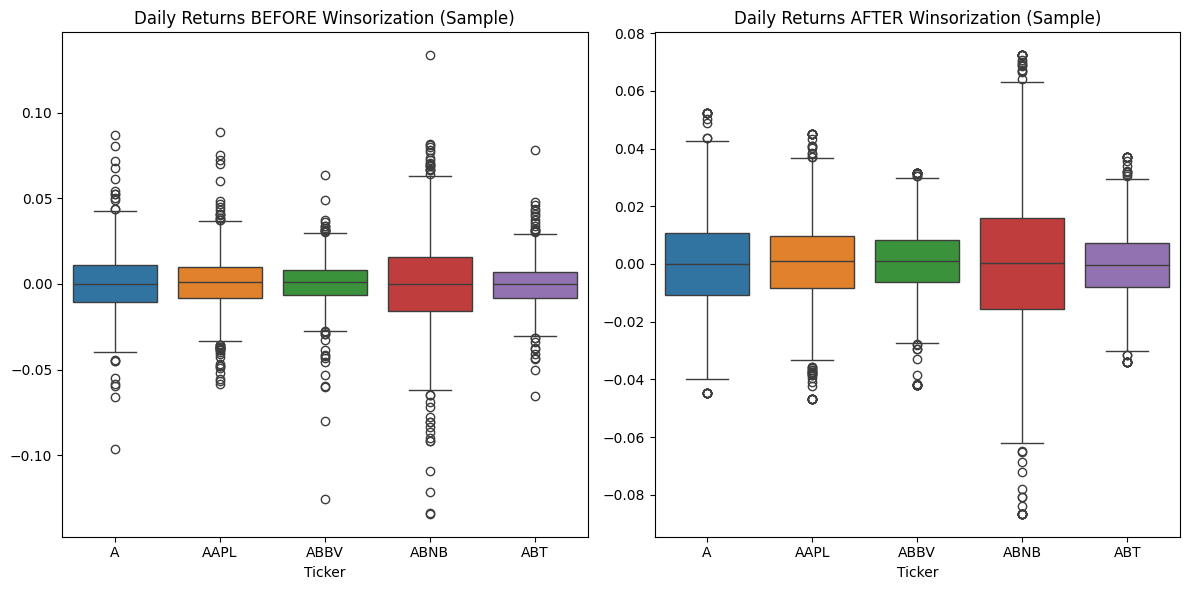

In [6]:
#============================================================================
# Winsorization
#============================================================================

from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Daily Returns based on the cleaned data
daily_returns = stock_data_clean.pct_change().dropna()

# Apply Winsorization to limit the highest and lowest 1% of values across each stock
# axis=0 applies the winsorization function column-wise (per stock)
winsorized_returns = daily_returns.apply(
    lambda x: winsorize(x, limits=[0.01, 0.01]), axis=0, result_type='broadcast'
)

print("--- Winsorization Applied to Daily Returns ---")

# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 columns

# Plot the Daily Returns BEFORE Winsorization in the first subplot
sns.boxplot(data=daily_returns.iloc[:, :5], ax=axes[0])
axes[0].set_title('Daily Returns BEFORE Winsorization (Sample)')

# Plot the Daily Returns AFTER Winsorization in the second subplot
sns.boxplot(data=winsorized_returns.iloc[:, :5], ax=axes[1])
axes[1].set_title('Daily Returns AFTER Winsorization (Sample)')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [7]:
# ============================================================================
# TASK 2: Daily Return, Beta, Annual Volatility
# ============================================================================

# Use stock_data_clean which contains the cleaned 'Close' prices
close_prices = stock_data_clean

# (a) Daily Return
daily_returns = close_prices.pct_change().dropna()
display(daily_returns)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,-0.033806,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,0.018559,...,0.012818,-0.003190,0.006329,0.037614,0.010608,-0.046943,0.005347,0.010145,0.006337,-0.038072
2022-01-05,-0.017131,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,-0.007809,...,-0.024824,-0.037033,0.009799,0.012437,-0.013629,-0.082134,-0.012677,-0.003296,-0.050068,-0.038024
2022-01-06,0.003499,-0.016694,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,0.008891,...,0.007986,0.004629,-0.007821,0.023521,-0.001373,0.008154,0.010331,-0.008307,-0.005410,0.003971
2022-01-07,-0.026623,0.000988,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026242,0.008524,...,-0.001238,-0.001063,0.008759,0.008197,-0.007992,-0.021568,-0.011467,-0.006050,-0.043771,-0.029114
2022-01-10,0.000069,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009240,0.001719,...,-0.004710,-0.028149,0.010999,-0.005952,-0.010136,0.020772,-0.013964,-0.009754,0.008571,0.007153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011144,0.011478,0.009025,0.003494,0.003937,0.006298,0.007972,0.002686,0.014891,0.004364,...,0.006410,0.007604,0.007236,0.000941,0.005446,0.020047,0.008516,0.004494,0.012262,0.002557
2024-12-26,-0.001984,0.003176,-0.004444,0.002445,0.004444,0.002806,-0.003318,0.004956,-0.000138,-0.000395,...,-0.003185,0.005970,-0.000440,0.000846,0.002708,0.004392,0.007407,-0.000466,0.003566,0.004979
2024-12-27,-0.002135,-0.013242,-0.006641,-0.014300,-0.002429,-0.006349,-0.011792,-0.008175,-0.004907,-0.000593,...,-0.006390,-0.007054,-0.000587,-0.000094,-0.007935,-0.027438,-0.005662,-0.003543,-0.019604,-0.005558


In [8]:
# ============================================================================
# TASK 2(b):Beta Calculation
# ============================================================================

# Calculate daily returns for the market
# Explicitly select the 'Close' price for the market ticker and ensure it's a Series named 'Market'
market_daily_returns = market_data.loc[:, ('Close', market_ticker)].pct_change().dropna()
market_daily_returns.name = 'Market'

# Align stock and market daily returns
aligned = pd.concat([daily_returns, market_daily_returns], axis=1).dropna()

# Calculate the standard deviation of the market index returns
market_std = aligned['Market'].std()

# Prepare lists to store calculated metrics
metrics = []
stock_stds = aligned[daily_returns.columns].std()
stock_means = aligned[daily_returns.columns].mean()

for ticker in daily_returns.columns:
    stock_returns = aligned[ticker]
    stock_std = stock_stds[ticker]

    # 1. Find the correlation of returns between stock and index
    correlation = stock_returns.corr(aligned['Market'])

    # 2. Apply the Beta formula
    beta_calc = correlation * (stock_std / market_std)

    metrics.append({
        'Ticker': ticker,
        'Daily_Return_Mean': stock_means[ticker],
        'Stock_Std': stock_std,
        'Beta': beta_calc
    })

metrics_df = pd.DataFrame(metrics).set_index('Ticker').dropna()
display(metrics_df)

,Daily_Return_Mean,Stock_Std,Beta
Ticker,,,
A,-0.000002,0.018663,1.026503
AAPL,0.000591,0.017067,1.210071
ABBV,0.000610,0.013856,0.301203
ABNB,0.000074,0.029473,1.660306
ABT,-0.000106,0.013723,0.675053
...,...,...,...
XYZ,-0.000034,0.041187,2.541251
YUM,0.000126,0.012053,0.633211
ZBH,-0.000076,0.015443,0.738053


In [9]:
# ============================================================================
# TASK 2(c):Annual Volatility
# ============================================================================

#Formula: Annual Volatility = Daily Return Standard Deviation × √𝟐𝟓𝟐
# Calculate Annual Volatility using the stock standard deviation (Stock_Std) and 252 trading days
metrics_df['Annual_Volatility'] = metrics_df['Stock_Std'] * np.sqrt(252)

# Prepare the final feature set for clustering
X_clustering = metrics_df[['Beta', 'Annual_Volatility', 'Daily_Return_Mean']]
print("Metrics DataFrame :")
display(metrics_df)

Metrics DataFrame :


,Daily_Return_Mean,Stock_Std,Beta,Annual_Volatility
Ticker,,,,
A,-0.000002,0.018663,1.026503,0.296259
AAPL,0.000591,0.017067,1.210071,0.270935
ABBV,0.000610,0.013856,0.301203,0.219958
ABNB,0.000074,0.029473,1.660306,0.467875
ABT,-0.000106,0.013723,0.675053,0.217839
...,...,...,...,...
XYZ,-0.000034,0.041187,2.541251,0.653825
YUM,0.000126,0.012053,0.633211,0.191335
ZBH,-0.000076,0.015443,0.738053,0.245157


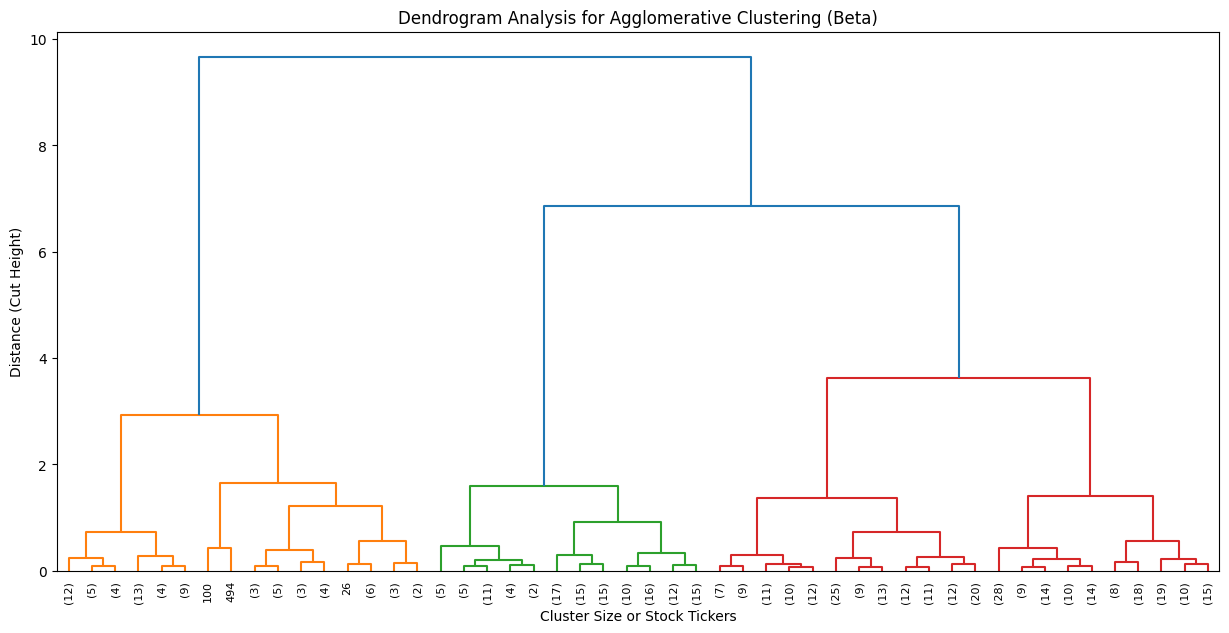

In [10]:
# ============================================================================
# TASK 3(b):Identify the best value of K (Dendrogram Analysis)
# ============================================================================

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Prepare data (Beta metric only) - moved from sUIxEOjTE5tn
X_beta = X_clustering[['Beta']]

# Calculate the linkage matrix using the 'ward' method, minimizing variance
linked_matrix = linkage(X_beta, method='ward')

# Plot the Dendrogram
plt.figure(figsize=(15, 7))
dendrogram(
    linked_matrix,
    orientation='top',

    truncate_mode='lastp', p=50, # Show only the last 50 merged clusters
    show_leaf_counts=True
)
plt.title('Dendrogram Analysis for Agglomerative Clustering (Beta)')
plt.xlabel('Cluster Size or Stock Tickers')
plt.ylabel('Distance (Cut Height)')
# Look for the distance level where the vertical lines intersect K times (e.g., K=3 or 4)
plt.axhline(y=15, color='r', linestyle='--')
plt.show()

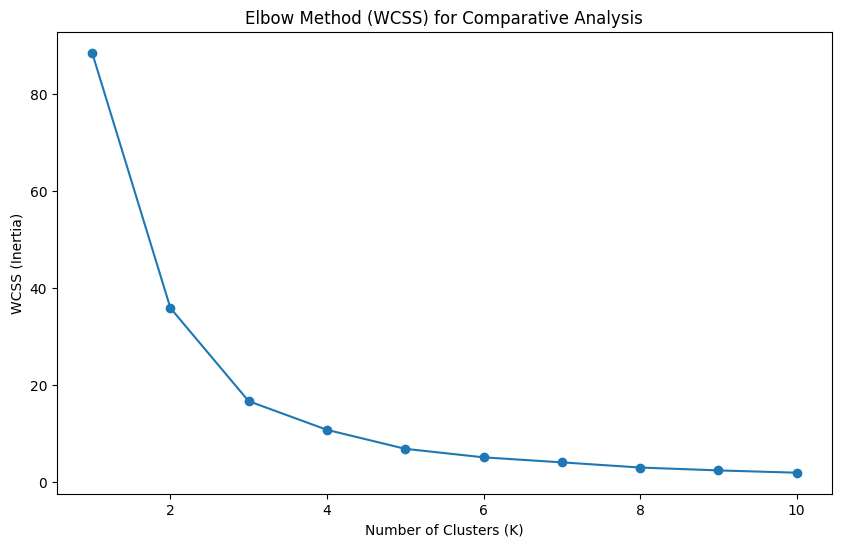

In [11]:
# ============================================================================
# TASK 3(b):Identify the best value of K (Elbow Method )
# ============================================================================

from sklearn.cluster import KMeans

# Calculate WCSS (Within-Cluster Sum of Squares)
wcss = []
K_range = range(1, 11)

for k in K_range:
    # Use KMeans to calculate inertia (WCSS)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_beta)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method (WCSS) for Comparative Analysis')
plt.show()

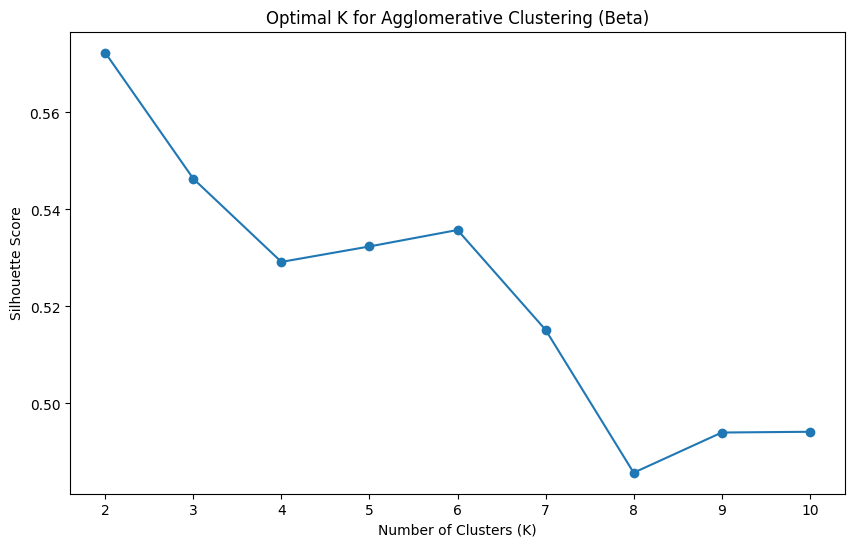

In [12]:
# ============================================================================
# TASK 3(b):Identify the best value of K (Silhouette Method)
# ============================================================================
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Prepare data (Beta metric only)
X_beta = X_clustering[['Beta']]

# Testing number of clusters from 2 to 10 and collecting the silhouette scores
range_n_clusters = range(2, 11)
silhouette_scores_agglom = []

for n_clusters in range_n_clusters:
    # Agglomerative Clustering (using default linkage, often Ward, as suggested in source)
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglom.fit_predict(X_beta)

    if len(set(labels)) > 1:
        score = silhouette_score(X_beta, labels)
        silhouette_scores_agglom.append(score)
    else:
        # Handle case where fewer than 2 clusters are formed
        silhouette_scores_agglom.append(0)

# Visualization of Silhouette Scores to determine optimal K
plt.figure(figsize=(10, 6))
plt.plot(list(range_n_clusters)[:len(silhouette_scores_agglom)], silhouette_scores_agglom, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Optimal K for Agglomerative Clustering (Beta)')
plt.show()

Stocks clustered into 4 Agglomerative groups.


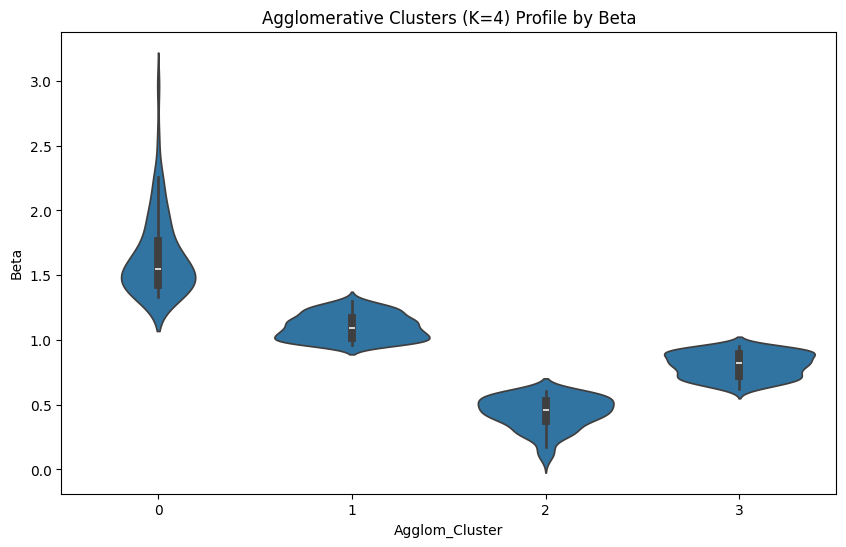

In [13]:
# ============================================================================
# TASK 3(c):Implementation of Agglomerative Clustering
# ============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Select the optimal K based on the Silhouette plot (e.g., K=4)
optimal_K_agglom = 4

# Implement final Agglomerative Clustering model
final_agglom_model = AgglomerativeClustering(n_clusters=optimal_K_agglom)
X_clustering['Agglom_Cluster'] = final_agglom_model.fit_predict(X_beta)

print(f"Stocks clustered into {optimal_K_agglom} Agglomerative groups.")

# Visualize the cluster profiles (as demonstrated in source [20])
plt.figure(figsize=(10, 6))
sns.violinplot(x='Agglom_Cluster', y='Beta', data=X_clustering)
plt.title(f'Agglomerative Clusters (K={optimal_K_agglom}) Profile by Beta')
plt.show()

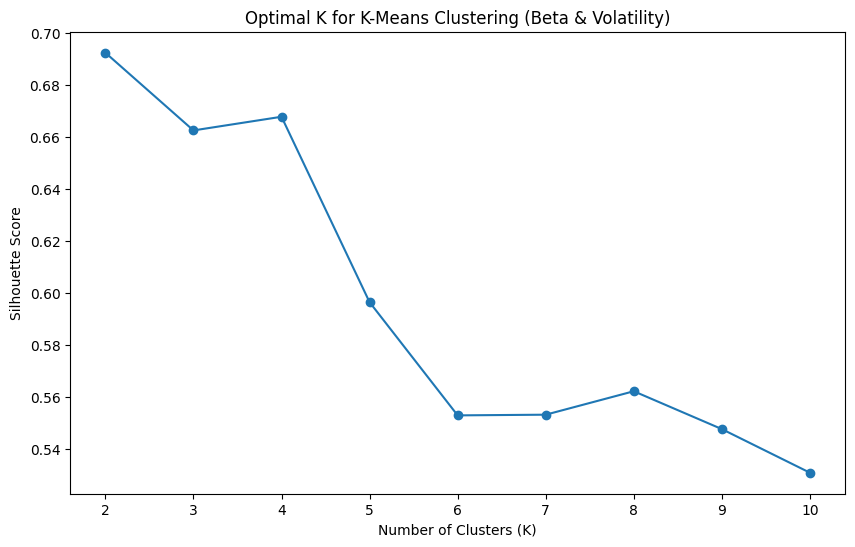

In [14]:
# ============================================================================
# TASK 4(b): Identify the best value of K (Silhouette Method)
# ============================================================================
#We use a pipeline to combine Normalization and K-Means for efficiency, as shown in the sources.
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Prepare data (Beta and Annual Volatility metrics)
X_kmeans_raw = X_clustering[['Beta', 'Annual_Volatility']]

# Define Normalizer and ranges for K
normalizer = Normalizer()
range_n_clusters = range(2, 11)
silhouette_scores_kmeans = []

for n_clusters in range_n_clusters:
    # Create K-Means model [25]
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=42, n_init='auto')

    # Make a pipeline chaining normalizer and kmeans [25]
    pipeline = make_pipeline(normalizer, kmeans)

    # Fit the pipeline
    pipeline.fit(X_kmeans_raw)
    labels = pipeline.predict(X_kmeans_raw)

    if len(set(labels)) > 1:
        # Calculate silhouette score on the normalized data
        X_normalized = normalizer.fit_transform(X_kmeans_raw)
        score = silhouette_score(X_normalized, labels)
        silhouette_scores_kmeans.append(score)
    else:
        silhouette_scores_kmeans.append(0)

# Visualization of Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(list(range_n_clusters)[:len(silhouette_scores_kmeans)], silhouette_scores_kmeans, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Optimal K for K-Means Clustering (Beta & Volatility)')
plt.show()

Stocks clustered into 5 K-Means tiered groups.


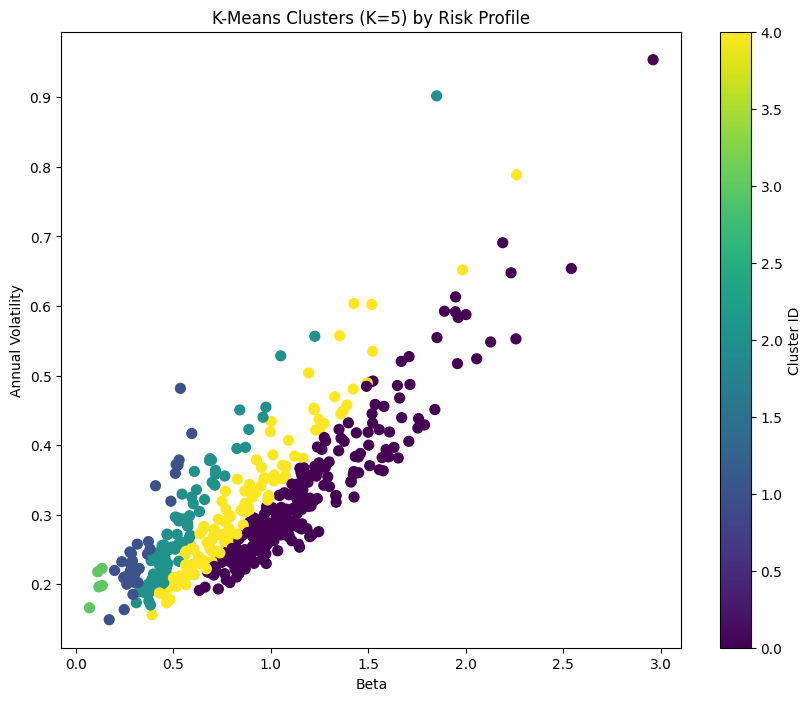

In [15]:
# ============================================================================
# TASK 4(c): Implementation of K-Means using Python via Google Colab
# ============================================================================

#Assuming K=5 is chosen based on analysis.
# Select the optimal K based on the Silhouette plot (e.g., K=5)
optimal_K_kmeans = 5

# Implement final K-Means Clustering model via pipeline
kmeans_final = KMeans(n_clusters=optimal_K_kmeans, max_iter=1000, random_state=42, n_init='auto')
pipeline_final = make_pipeline(normalizer, kmeans_final)

# Fit and predict the final labels
X_clustering['KMeans_Cluster'] = pipeline_final.fit_predict(X_kmeans_raw)

print(f"Stocks clustered into {optimal_K_kmeans} K-Means tiered groups.")

# Visualization: Scatter plot based on the two dimensions
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_clustering['Beta'], X_clustering['Annual_Volatility'],
                      c=X_clustering['KMeans_Cluster'], cmap='viridis', s=50)
plt.xlabel('Beta')
plt.ylabel('Annual Volatility')
plt.title(f'K-Means Clusters (K={optimal_K_kmeans}) by Risk Profile')
plt.colorbar(scatter, label='Cluster ID')
plt.show()

In [16]:
# ============================================================================
# TASK 5: Implementation using Python via Google Colab
# ============================================================================

#The implementation focuses on summarizing the statistical properties of the resulting clusters to profile them.
# Review Agglomerative Clusters (Based on Beta only)
print("--- Agglomerative Cluster Profiles (Beta Segmentation) ---")
agglom_profile = X_clustering.groupby('Agglom_Cluster')[['Beta', 'Annual_Volatility', 'Daily_Return_Mean']].mean()
agglom_profile['Count'] = X_clustering['Agglom_Cluster'].value_counts()
display(agglom_profile.sort_values(by='Beta'))

# Review K-Means Clusters (Based on Beta and Annual Volatility)
print("\n--- K-Means Cluster Profiles (Tiered Segmentation) ---")
kmeans_profile = X_clustering.groupby('KMeans_Cluster')[['Beta', 'Annual_Volatility', 'Daily_Return_Mean']].mean()
kmeans_profile['Count'] = X_clustering['KMeans_Cluster'].value_counts()
display(kmeans_profile.sort_values(by=['Beta', 'Annual_Volatility']))

# Displaying examples of stocks in each K-Means cluster
for cluster_id in sorted(X_clustering['KMeans_Cluster'].unique()):
    tickers_in_cluster = X_clustering[X_clustering['KMeans_Cluster'] == cluster_id].index.tolist()
    print(f"\nCluster {cluster_id} ({kmeans_profile.loc[cluster_id]['Count']} stocks):")
    # Show the first 5 tickers for demonstration
    print(tickers_in_cluster[:5])

--- Agglomerative Cluster Profiles (Beta Segmentation) ---


,Beta,Annual_Volatility,Daily_Return_Mean,Count
Agglom_Cluster,,,,
2,0.437671,0.237098,0.000367,127
3,0.805757,0.271966,0.000334,151
1,1.103492,0.326549,0.000447,145
0,1.647961,0.475903,0.000570,76



--- K-Means Cluster Profiles (Tiered Segmentation) ---


,Beta,Annual_Volatility,Daily_Return_Mean,Count
KMeans_Cluster,,,,
3,0.113448,0.200490,0.000112,5
1,0.344043,0.260574,0.000285,31
2,0.559910,0.285391,0.000490,81
4,0.853001,0.313263,0.000348,122
0,1.160975,0.324160,0.000437,260



Cluster 0 (260.0 stocks):
['A', 'AAPL', 'ABNB', 'ABT', 'ACN']

Cluster 1 (31.0 stocks):
['ABBV', 'BMY', 'CAG', 'CBOE', 'CF']

Cluster 2 (81.0 stocks):
['ACGL', 'ADM', 'AEE', 'AEP', 'ALL']

Cluster 3 (5.0 stocks):
['CPB', 'GIS', 'K', 'KVUE', 'SOLV']

Cluster 4 (122.0 stocks):
['AES', 'AFL', 'AIZ', 'AKAM', 'ALB']
